In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import librosa
import librosa.display
import torch.optim as optim
import os
from scipy.io import wavfile
import sys
from sklearn.model_selection import train_test_split
import random

In [ ]:
def addRandomNoise(labels,audioFiles,noiseLevelDB=-40):
    data=[]
    labelsNoisy=[]
    gain = 10**(noiseLevelDB / 20)
    for i,x in enumerate(audioFiles):
        num_samples=len(x)
        x2=x+ (np.random.normal(0, 1, size=num_samples)*random.uniform(0,gain))
        data.append(x2)
        labelsNoisy.append(labels[i])

    return labelsNoisy,data






def readAndSegmentFiles(directories, windowSize, noiseLevelDB=-40,addNoise=True):
    ytemp = []
    N = []
    ytraintemp = []
    Ntrain = []

    base_path = 'sounds'

    for directory in directories:
        directory_path = os.path.join(base_path, directory)


        files = os.listdir(directory_path)

        for filename in files:
            file_path = os.path.join(directory_path, filename)

            audio_data, sample_rate = librosa.load(file_path, sr=8000)

            N.append(audio_data)
            ytemp.append(directories.index(directory))

    samplePerSegment = int(sample_rate * windowSize)
    audioSegments = []
    y = []

    for idt in range(len(N)):
        track = N[idt]
        for i in range(0, len(track), samplePerSegment):
            if i + samplePerSegment <= len(track):
                audioSegments.append(track[i:i+samplePerSegment])
                y.append(ytemp[idt])

    if addNoise:
      y, audioSegments = addRandomNoise(y, audioSegments, noiseLevelDB)

    X_train, X_test, y_train, y_test = train_test_split(audioSegments, y, test_size=0.2, random_state=42, stratify=y)

    return X_train, y_train, X_test, y_test

















In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
class CNNNetwork(nn.Module):
    def __init__(self, input_size=96,  num_classes=5):
        super().__init__()

        self.conv1=nn.Conv2d(1, 16, kernel_size=3, padding=1,stride=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling


        self.conv2=nn.Conv2d(16, 32, kernel_size=3, padding=1,stride=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling

        self.conv3=nn.Conv2d(32, 64, kernel_size=3, padding=1,stride=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.fc1=nn.Linear(64*360 ,1000)
        self.fc2=nn.Linear(1000 ,100)
        self.fc3=nn.Linear(100 ,5)




    def forward(self, x, return_features=False):
        x = x.unsqueeze(1)
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)
        x1_p = self.pool1(x1)

        x2 = self.conv2(x1_p)
        x2 = self.bn2(x2)
        x2 = F.relu(x2)
        x2_p = self.pool2(x2)

        x3 = self.conv3(x2_p)
        x3 = self.bn3(x3)
        x3 = F.relu(x3)

        if return_features:
            return [x1, x2, x3]

        x_flat = torch.flatten(x3, start_dim=1)
        x_out = self.fc1(x_flat)
        x_out = F.relu(x_out)
        x_out = self.fc2(x_out)
        x_out = F.relu(x_out)
        x_out = self.fc3(x_out)

        return x_out

In [ ]:

directories = ["N","AS","MR","MS","MVP"]
data,y,audioSegmentsTest,yTest=readAndSegmentFiles(directories,1,-22,False)

log_mel_spectrogram_list = []
log_mel_spectrogram_list_test=[]
for track in data:
    mel_spectrogram = librosa.feature.melspectrogram(y=track, sr=8000, n_fft=256, hop_length=128, n_mels=96)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    log_mel_spectrogram_list.append(log_mel_spectrogram)

for track in audioSegmentsTest:
    mel_spectrogram = librosa.feature.melspectrogram(y=track, sr=8000, n_fft=256, hop_length=128, n_mels=96)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    log_mel_spectrogram_list_test.append(log_mel_spectrogram)

In [ ]:
#normalization
all_specs = np.concatenate(log_mel_spectrogram_list, axis=1)
mean = np.mean(all_specs)
std = np.std(all_specs)
log_mel_spectrogram_list = [(spec - mean) / std for spec in log_mel_spectrogram_list]
log_mel_spectrogram_list_test = [(spec - mean) / std for spec in log_mel_spectrogram_list_test]


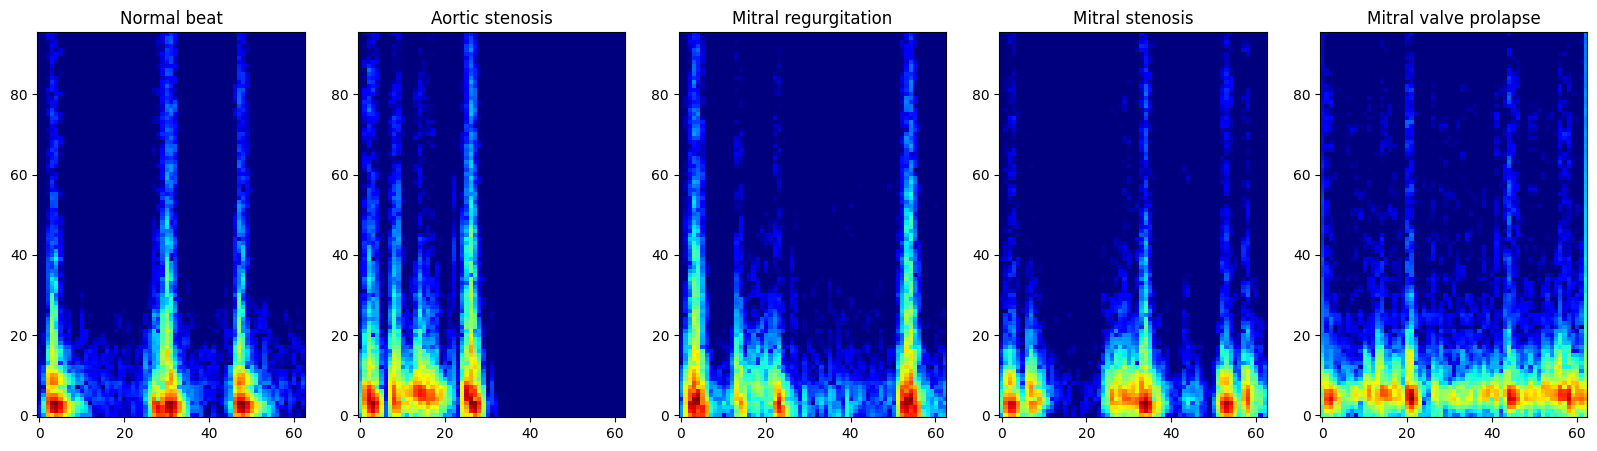

In [ ]:
figure, ax = plt.subplots(1, 5, figsize=(20, 5))

ax[0].imshow(log_mel_spectrogram_list[0], cmap="jet" , aspect='auto', origin='lower')
ax[0].set_title('Normal beat')
ax[1].imshow(log_mel_spectrogram_list[14], cmap="jet" , aspect='auto', origin='lower')
ax[1].set_title('Aortic stenosis')
ax[2].imshow(log_mel_spectrogram_list[8], cmap="jet" , aspect='auto', origin='lower')
ax[2].set_title('Mitral regurgitation')
ax[3].imshow(log_mel_spectrogram_list[15], cmap="jet" , aspect='auto', origin='lower')
ax[3].set_title('Mitral stenosis')
ax[4].imshow(log_mel_spectrogram_list[21], cmap="jet" , aspect='auto', origin='lower')
ax[4].set_title('Mitral valve prolapse')
plt.show()

In [ ]:
data = torch.tensor(log_mel_spectrogram_list, dtype=torch.float32)
data=data.transpose(1,2)
print("Data shape:", data.shape)
y = torch.tensor(y, dtype=torch.long)
print("label shape:", y.shape)
train_data = TensorDataset(data, y)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

Data shape: torch.Size([1604, 63, 96])
label shape: torch.Size([1604])


<ipython-input-13-f874814d9a83>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  data = torch.tensor(log_mel_spectrogram_list, dtype=torch.float32)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
model = CNNNetwork().to(device)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000006)

CNNNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=23040, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=5, bias=True)
)


In [ ]:
num_epochs = 500

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/500], Loss: 1.4714
Epoch [2/500], Loss: 1.1898
Epoch [3/500], Loss: 0.9594
Epoch [4/500], Loss: 0.7965
Epoch [5/500], Loss: 0.6482
Epoch [6/500], Loss: 0.5331
Epoch [7/500], Loss: 0.4803
Epoch [8/500], Loss: 0.4100
Epoch [9/500], Loss: 0.3944
Epoch [10/500], Loss: 0.3226
Epoch [11/500], Loss: 0.3050
Epoch [12/500], Loss: 0.2535
Epoch [13/500], Loss: 0.2285
Epoch [14/500], Loss: 0.2119
Epoch [15/500], Loss: 0.2009
Epoch [16/500], Loss: 0.1803
Epoch [17/500], Loss: 0.1598
Epoch [18/500], Loss: 0.1576
Epoch [19/500], Loss: 0.1482
Epoch [20/500], Loss: 0.1363
Epoch [21/500], Loss: 0.1214
Epoch [22/500], Loss: 0.1093
Epoch [23/500], Loss: 0.1060
Epoch [24/500], Loss: 0.0925
Epoch [25/500], Loss: 0.0908
Epoch [26/500], Loss: 0.0855
Epoch [27/500], Loss: 0.0793
Epoch [28/500], Loss: 0.0753
Epoch [29/500], Loss: 0.0680
Epoch [30/500], Loss: 0.0660
Epoch [31/500], Loss: 0.0609
Epoch [32/500], Loss: 0.0569
Epoch [33/500], Loss: 0.0585
Epoch [34/500], Loss: 0.0520
Epoch [35/500], Loss: 0

In [ ]:
import time

allPrededicted=[]
allReal=[]
maxTime=0
for x in range(len(log_mel_spectrogram_list_test)):
    example = torch.tensor(log_mel_spectrogram_list_test[x], dtype=torch.float32).unsqueeze(0)
    example=example.transpose(1,2)
    model.eval()

    start_time = time.perf_counter()
    with torch.no_grad():
        example = example.to(device)
        output = model(example)
    end_time = time.perf_counter()

    maxTime=max(maxTime,end_time-start_time)
    predicted_class = torch.argmax(output, dim=1).item()
    real_class = yTest[x]
    allPrededicted.append(predicted_class)
    allReal.append(real_class)
print(f'Max inference time: {maxTime}')


Max inference time: 0.0089612000000443


In [ ]:
correct=0
wrong=0
for x in range(len(allPrededicted)):
    if allPrededicted[x]==allReal[x]:
        correct=correct+1
    else:
        wrong=wrong+1

print(f'Correct: {correct}')
print(f'Wrong: {wrong}')

Correct: 389
Wrong: 12


Accuracy: 0.970074812967581
Precision: 0.9704568517842052
Recall: 0.9694026903329229
F1 Score: 0.9691657553133792


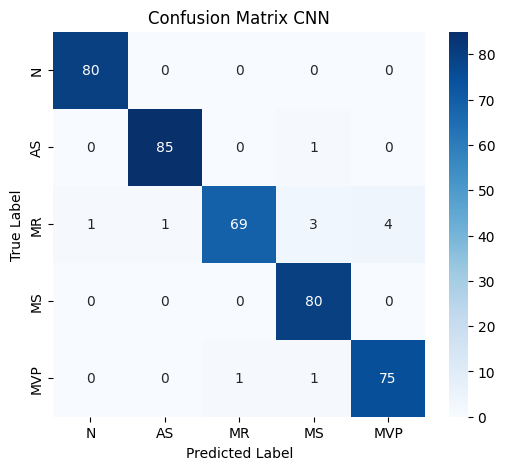

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
import matplotlib.pyplot as plt
import seaborn as sns


accuracy = accuracy_score(allReal,allPrededicted)
precision = precision_score(allReal,allPrededicted,average='macro')
recall = recall_score(allReal,allPrededicted,average='macro')
f1 = f1_score(allReal,allPrededicted,average='macro')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
cm=confusion_matrix(allReal,allPrededicted)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",xticklabels=["N","AS","MR","MS","MVP"],
            yticklabels=["N","AS","MR","MS","MVP"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CNN")
plt.show()
